In [10]:
import serial.tools.list_ports

for p in serial.tools.list_ports.comports():
    print(p.device, p.description)


COM5 Standard Serial over Bluetooth link (COM5)
COM4 Standard Serial over Bluetooth link (COM4)
COM17 Silicon Labs CP210x USB to UART Bridge (COM17)


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from software.fieldview import FieldView
from software.protocol import unpack_frame  # used for streaming loop

PORT = "COM17"
HZ = 50
N_SENSORS = 6

fv = FieldView(PORT)

In [12]:
fv.ping()

'OK'

In [13]:
fv.info()

'INFO sensors=6 frame_bytes=106'

xyz: (800, 6, 3)


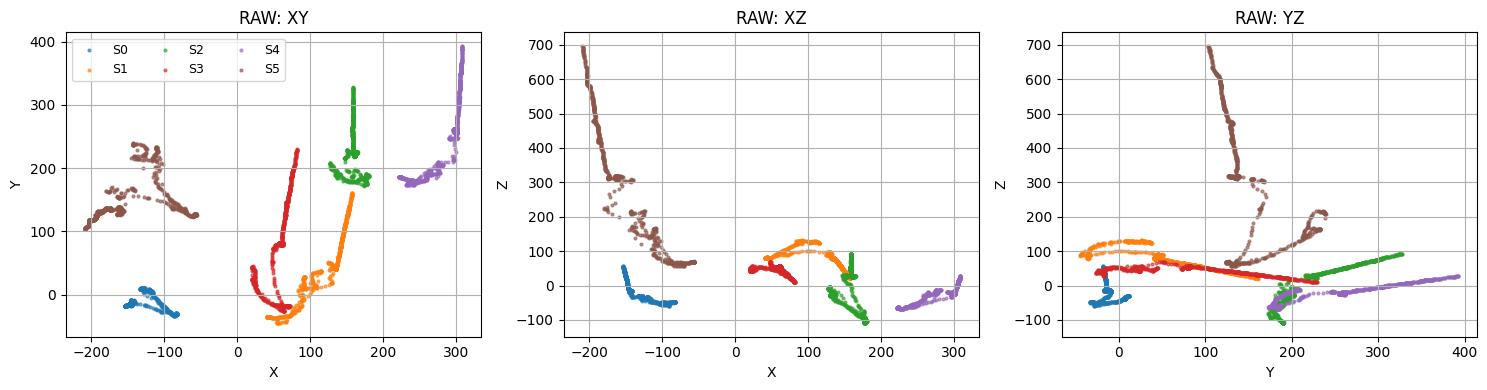

In [14]:
# Collect N frames in streaming mode (keeps port open only inside this cell)
N_FRAMES = 800

t = fv.start(HZ)
frames = []
for _ in range(N_FRAMES):
    raw = t.read_bin_frame()
    if raw:
        _, _, arr = unpack_frame(raw)      # arr shape (6,4)
        frames.append(arr[:, :3].copy())   # keep xyz only
fv.stop(t)

xyz = np.stack(frames, axis=0)  # (T, 6, 3)
print("xyz:", xyz.shape)

def plot_planes(xyz, title="RAW", max_points=2000):
    if xyz.shape[0] > max_points:
        xyzp = xyz[-max_points:]
    else:
        xyzp = xyz

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    planes = [("X","Y",0,1), ("X","Z",0,2), ("Y","Z",1,2)]

    for ax, (xl, yl, xi, yi) in zip(axes, planes):
        for s in range(N_SENSORS):
            ax.scatter(xyzp[:, s, xi], xyzp[:, s, yi], s=4, alpha=0.6, label=f"S{s}")
        ax.set_xlabel(xl); ax.set_ylabel(yl)
        ax.set_title(f"{title}: {xl}{yl}")
        ax.grid(True)

    axes[0].legend(ncol=3, fontsize=9, loc="best")
    plt.tight_layout()
    plt.show()

plot_planes(xyz, "RAW")


offsets:
 [[ -88.862564  -46.45683   -66.7738  ]
 [  46.983543  -51.628517   61.79079 ]
 [ 195.79245   171.95248  -101.17775 ]
 [  86.052246  -34.39191    37.18784 ]
 [ 232.28415   166.97522   -79.7569  ]
 [ -66.18207   109.01199    51.857056]]
scales:
 [[1.4364688  0.8135039  0.9305805 ]
 [1.4627277  0.9049307  0.8255669 ]
 [0.8143428  0.9130945  1.4774557 ]
 [0.8184581  0.9005535  1.4975393 ]
 [1.4404932  0.91283035 0.8262417 ]
 [1.4065286  0.8157435  0.9405973 ]]


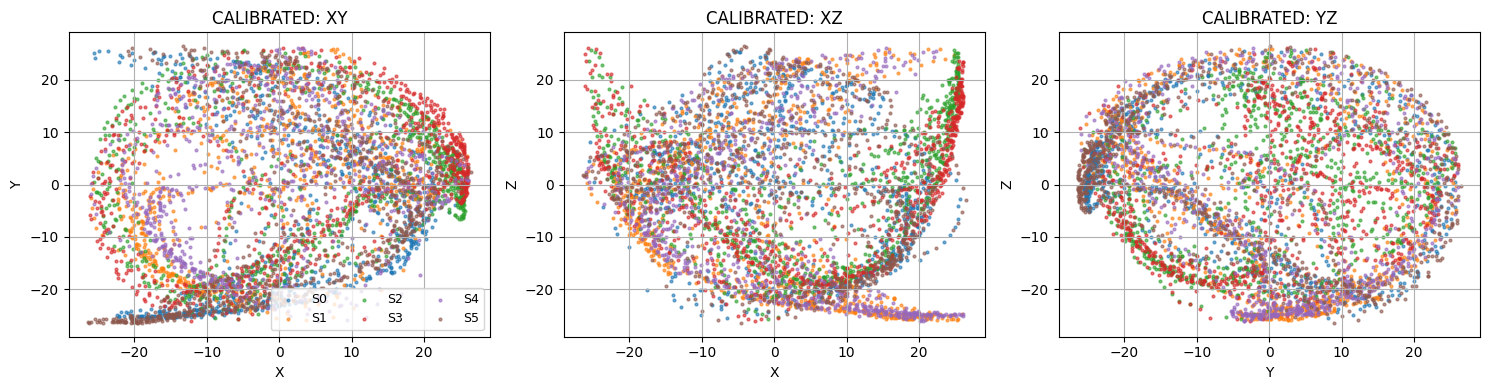

In [9]:
def calibrate_minmax(points_xyz):
    mn = points_xyz.min(axis=0)
    mx = points_xyz.max(axis=0)

    offset = (mx + mn) / 2.0
    r = (mx - mn) / 2.0
    r[r == 0] = 1.0

    avg_radius = r.mean()
    if avg_radius == 0:
        avg_radius = 1.0

    scale = avg_radius / r
    return offset, scale

offsets = np.zeros((N_SENSORS, 3), dtype=np.float32)
scales  = np.ones((N_SENSORS, 3), dtype=np.float32)

for s in range(N_SENSORS):
    off, sc = calibrate_minmax(xyz[:, s, :])
    offsets[s] = off
    scales[s] = sc

xyz_cal = (xyz - offsets[None, :, :]) * scales[None, :, :]

print("offsets:\n", offsets)
print("scales:\n", scales)

plot_planes(xyz_cal, "CALIBRATED")
